In [51]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import load_model
from sklearn.preprocessing import MinMaxScaler
import joblib

In [55]:
from google.colab import files
uploaded = files.upload()

Saving predicted_return_with_LSTM (1).csv to predicted_return_with_LSTM (1).csv


## load neccessey files

In [57]:
df = pd.read_csv("TSLA return_asset (3).csv")
test_predictions_df.to_csv("predicted_return_with_LSTM (1).csv", index=False)
train_size=int(len(df)*0.9)
train_data=df.iloc[:train_size]
test_data=df.iloc[train_size:]

## Load Model and Scaler

In [61]:
model = load_model(
    'LSTM_model.h5',
    custom_objects={"mse": tf.keras.losses.MeanSquaredError()}
)

In [58]:
scaler = MinMaxScaler()
scaler.fit(train_data[['TSLA']])
joblib.dump(scaler, 'scaler.pkl')
scaler = joblib.load('scaler.pkl')

## repare Last Window for Forecast

In [59]:
# Assuming df is your full dataset from Task 2
n_inputs = 12  # same as training time
n_features = 1

# Extract the last n_inputs values
last_window = scaler.transform(df[['TSLA']].values[-n_inputs:])
current_batch = last_window.reshape((1, n_inputs, n_features))

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


In [71]:
# Generate Future Dates
horizon_months = 12

# Generate future monthly dates
future_dates = pd.date_range(start=df.index[-1] + pd.offsets.MonthBegin(1), periods=horizon_months, freq='ME')

## Forecast Iteratively

In [72]:
preds_scaled = []

for i in range(horizon_months):
    pred_scaled = model.predict(current_batch, verbose=0)[0, 0]
    preds_scaled.append(pred_scaled)
    current_batch = np.append(current_batch[:, 1:, :], [[[pred_scaled]]], axis=1)

preds_scaled = np.array(preds_scaled).reshape(-1, 1)
preds = scaler.inverse_transform(preds_scaled).ravel()


## Calculate Confidence Intervals

In [73]:
# Assuming 'test_predictions' from Task 2 and 'data_test' in original scale exist
residuals = test_data - test_predictions_df
residuals_numeric = residuals['TSLA']
sigma = residuals_numeric.std(ddof=1)


# CI grows with sqrt(k)
k = np.arange(1, horizon_months + 1)
z = 1.96  # 95% CI
ci_half_width = z * sigma * np.sqrt(k)

lower = preds - ci_half_width
upper = preds + ci_half_width


## Plot Results

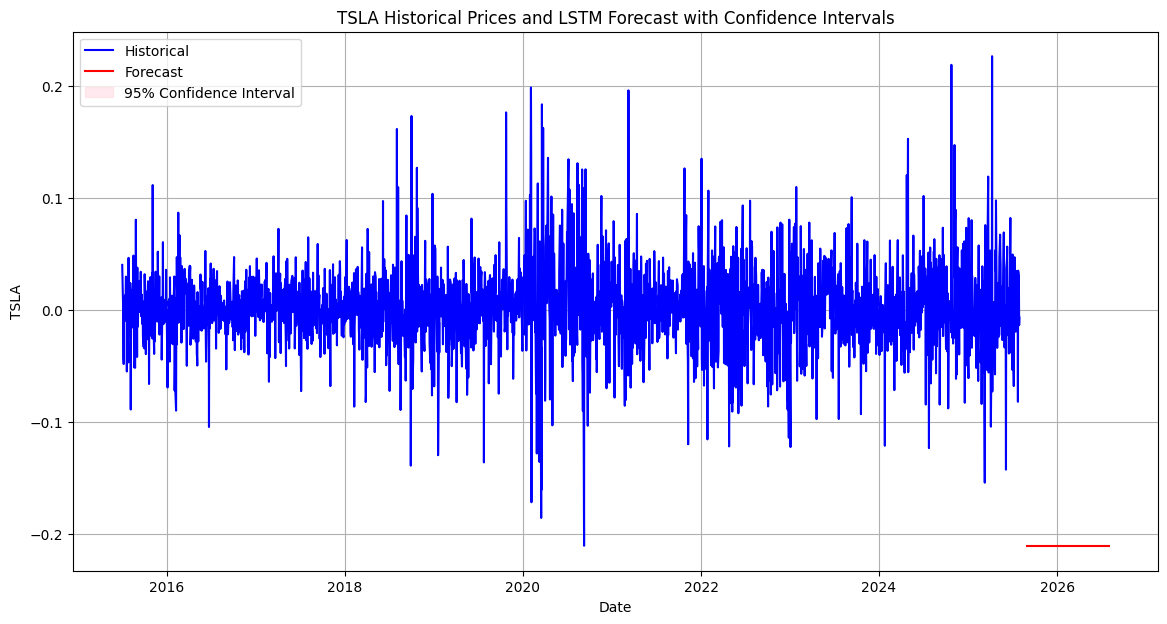

In [74]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 7))

# Plot historical data
plt.plot(df.index, df['TSLA'], label='Historical', color='blue')

# Plot forecasted values
plt.plot(future_dates, preds, label='Forecast', color='red')

# Plot confidence intervals (if available)
if lower is not None and upper is not None:
    plt.fill_between(future_dates, lower, upper, color='pink', alpha=0.3, label='95% Confidence Interval')

plt.xlabel('Date')
plt.ylabel('TSLA')
plt.title('TSLA Historical Prices and LSTM Forecast with Confidence Intervals')
plt.legend()
plt.grid(True)
plt.show()


In [76]:
# Save forecast CSV
forecast_df = pd.DataFrame({
    'Date': future_dates,
    'LSTM_Forecast': preds,
    'Lower_CI': lower,
    'Upper_CI': upper
})
forecast_df.to_csv('/content/drive/My Drive/my_folder/lstm_future_forecast.csv', index=False)

# Save model again (optional)
model.save('/content/drive/My Drive/my_folder/LSTM_model_task3.h5')


In [77]:
files.download('/content/drive/My Drive/my_folder/lstm_future_forecast.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>